In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
#import ConfigParser

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout2D, Activation
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
def double_conv_layer(x, size, dropout, batch_norm):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

In [3]:
#model = ZF_UNET_224()
#model.summary()
#model.load_weights("weights/zf_unet_224.h5") # optional

In [4]:
def UNET(dropout_val=0.2, batch_norm=True):
    OUTPUT_MASK_CHANNELS = 1
    if K.image_dim_ordering() == 'th':
        inputs = Input((3, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, 3))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters, 0, batch_norm)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters, 0, batch_norm)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters, 0, batch_norm)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters, 0, batch_norm)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters, 0, batch_norm)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters, 0, batch_norm)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters, 0, batch_norm)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters, 0, batch_norm)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters, 0, batch_norm)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters, 0, batch_norm)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val, batch_norm)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    
    model = Model(inputs, conv_final, name="ZF_UNET_224")
    model.load_weights("weights/zf_unet_224.h5")
    last_layer = model.get_layer('max_pooling2d_10').output
    
    for i in range(1,50):
        model.layers.pop()
    
    x = Flatten(name='flatten')(last_layer)
    x = Dense(8192, activation='relu', name='fc1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    output_layer = Dense(13, activation='softmax', name='output')(x)
    
    unet_model = Model(inputs, output_layer, name="UNET")
    
    return unet_model

In [6]:
model = UNET()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_23 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_24 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_24 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_25 (Activation)   (None, 224, 224, 32)      0         
__________

In [7]:
for layer in model.layers[:-4]:
    layer.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_23 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_24 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_24 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_25 (Activation)   (None, 224, 224, 32)      0         
__________

In [8]:
data_path = 'sample_labels.csv'
NIH_Data = pd.read_csv(data_path)

In [9]:
NIH_Data["Finding Labels"][0].split('|')[0] == 'Emphysema'

True

In [10]:
NIH_Data[:1]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139


In [11]:
train_data = NIH_Data[:2803] #50% of total data
test_data = NIH_Data[2803:5046] #40% of total data
validation_data = NIH_Data[5046:5607] #10% of total data

In [12]:
def getTarget(data):
    target = np.zeros([13])
    split_data = data.split('|')
    for i in range(0,len(split_data)):
        if(split_data[i] == 'Cardiomegaly'):
            target[0]=1
        if(split_data[i] == 'Emphysema'):
            target[1]=1
        if(split_data[i] == 'Atelectasis'):
            target[2]=1
        if(split_data[i] == 'Infiltration'):
            target[3]=1
        if(split_data[i] == 'Effusion'):
            target[4]=1
        if(split_data[i] == 'Pneumothorax'):
            target[5]=1
        if(split_data[i] == 'Pleural_Thickening'):
            target[6]=1
        if(split_data[i] == 'Edema'):
            target[7]=1
        if(split_data[i] == 'Mass'):
            target[8]=1
        if(split_data[i] == 'Nodule'):
            target[9]=1
        if(split_data[i] == 'Consolidation'):
            target[10]=1
        if(split_data[i] == 'Fibrosis'):
            target[11]=1
        if(split_data[i] == 'No Finding'):
            target[12]=1
            
    return target

In [13]:
def getDataTarget(data,start_val):
    data_targets = np.zeros([data.shape[0],13])
    for i in range(0,data.shape[0]):
        data_targets[i,:] = getTarget(data["Finding Labels"][i+start_val])
    return data_targets

In [14]:
def load_data(data,start_val):
    #print(data.shape[0])
    data_files = ["" for x in range(data.shape[0])]
    for i in range(0,data.shape[0]):
        #print(data["Image Index"][i+start_val])
        data_files[i] = ('images/'+data["Image Index"][i+start_val])
    data_files = np.asarray(data_files)
    #print(data_files)
    data_targets = getDataTarget(data,start_val)
    return data_files, data_targets

In [15]:
train_files, train_targets = load_data(train_data,0)
valid_files, valid_targets = load_data(validation_data,5046)
test_files, test_targets = load_data(test_data,2803)

In [16]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [17]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 2243/2243 [00:35<00:00, 63.76it/s]


(224, 224, 3)


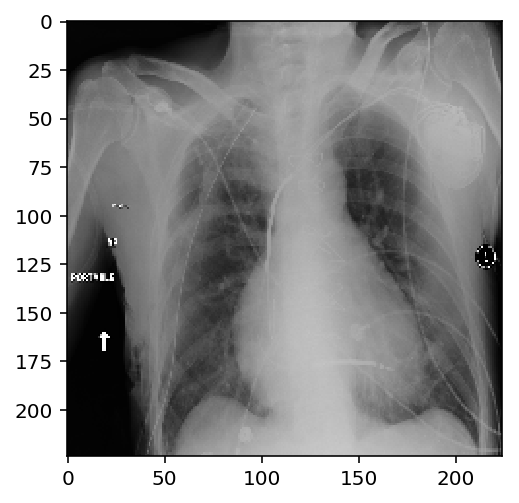

In [18]:
print(train_tensors[0].shape)
plt.imshow(train_tensors[1])

In [19]:
print(train_targets[0])

[ 0.  1.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.]


In [20]:
#model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.0001),
              metrics=['accuracy'])

In [21]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

In [22]:
history = AccuracyHistory()

In [23]:
model.fit(train_tensors, train_targets,
          batch_size=10,
          epochs=10,
          verbose=1,
          validation_data=(valid_tensors, valid_targets),
          callbacks=[history])

Train on 2803 samples, validate on 560 samples
Epoch 1/10
 220/2803 [=>............................] - ETA: 14:30 - loss: 2.7696 - acc: 0.3909

KeyboardInterrupt: 

In [ ]:
(loss, accuracy) = model.evaluate(test_tensors, test_targets, batch_size=10, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))